In [236]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mutual_info_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
sns.set_theme()

### EDA

In [237]:
def df_info2(df):
    df_info = pd.DataFrame()
    df_info['dtype'] = df.dtypes
    df_info['#'] = df.count()
    df_info['#na'] = df.isna().sum()
    df_info['#unique'] = df.nunique()
    df_info['min'] = df.min()
    df_info['max'] = df.max()
    return df_info

In [238]:
s3_file_path = 's3://datasets/kaggle/dgomonov/new-york-city-airbnb-open-data/data.parquet'
df = pd.read_parquet(s3_file_path, storage_options={
    'profile': 'local',
    'client_kwargs': {
        'endpoint_url': 'http://192.168.46.220:9000'
    }
}, columns=[
    'neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'price',
    'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'
])
df.head()

,neighbourhood_group,room_type,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,40.64749,-73.97237,149,1,9,0.21,6,365
1,Manhattan,Entire home/apt,40.75362,-73.98377,225,1,45,0.38,2,355
2,Manhattan,Private room,40.80902,-73.94190,150,3,0,NaN,1,365
3,Brooklyn,Entire home/apt,40.68514,-73.95976,89,1,270,4.64,1,194
4,Manhattan,Entire home/apt,40.79851,-73.94399,80,10,9,0.10,1,0


In [239]:
# column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# column values
for c in df.dtypes[df.dtypes == 'object'].index:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [240]:
df_info2(df)

,dtype,#,#na,#unique,min,max
neighbourhood_group,object,48895,0,5,bronx,staten_island
room_type,object,48895,0,3,entire_home/apt,shared_room
latitude,float64,48895,0,19048,40.49979,40.91306
longitude,float64,48895,0,14718,-74.24442,-73.71299
price,int64,48895,0,674,0,10000
minimum_nights,int64,48895,0,109,1,1250
number_of_reviews,int64,48895,0,394,0,629
reviews_per_month,float64,38843,10052,937,0.01,58.5
calculated_host_listings_count,int64,48895,0,47,1,327
availability_365,int64,48895,0,366,0,365


In [241]:
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [242]:
cat_columns = ['neighbourhood_group', 'room_type']
num_columns = list(set(df.columns) - set(cat_columns) - set(['price']))

### Question 1

What is the most frequent observation (mode) for the column `'neighbourhood_group'`?

In [243]:
df.neighbourhood_group.value_counts()

manhattan        21661
brooklyn         20104
queens            5666
bronx             1091
staten_island      373
Name: neighbourhood_group, dtype: int64

Ans: Manhattan

### Split the data

- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the `train_test_split` function) and set the seed to 42.
- Make sure that the target value ('price') is not in your dataframe.

In [244]:
df_X = df.loc[:, df.columns != 'price']
y = df['price'].values >= 152

In [245]:
df_train, df_test, y_train, y_test = train_test_split(df_X, y, test_size=0.4, random_state=42, shuffle=True)
df_val, df_test, y_val, y_test = train_test_split(df_test, y_test, test_size=0.5, shuffle=False)

### Question 2

- Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your train dataset.
  - In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
- What are the two features that have the biggest correlation in this dataset?

In [246]:
corr = df_train.corr()
corr

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.087732,0.027252,-0.010080,-0.014699,0.019442,-0.005975
longitude,0.087732,1.000000,-0.067251,0.058775,0.132226,-0.116669,0.080776
minimum_nights,0.027252,-0.067251,1.000000,-0.085092,-0.127316,0.124060,0.141089
number_of_reviews,-0.010080,0.058775,-0.085092,1.000000,0.581124,-0.072687,0.176481
reviews_per_month,-0.014699,0.132226,-0.127316,0.581124,1.000000,-0.047254,0.166533
calculated_host_listings_count,0.019442,-0.116669,0.124060,-0.072687,-0.047254,1.000000,0.222986
availability_365,-0.005975,0.080776,0.141089,0.176481,0.166533,0.222986,1.000000


<AxesSubplot:>

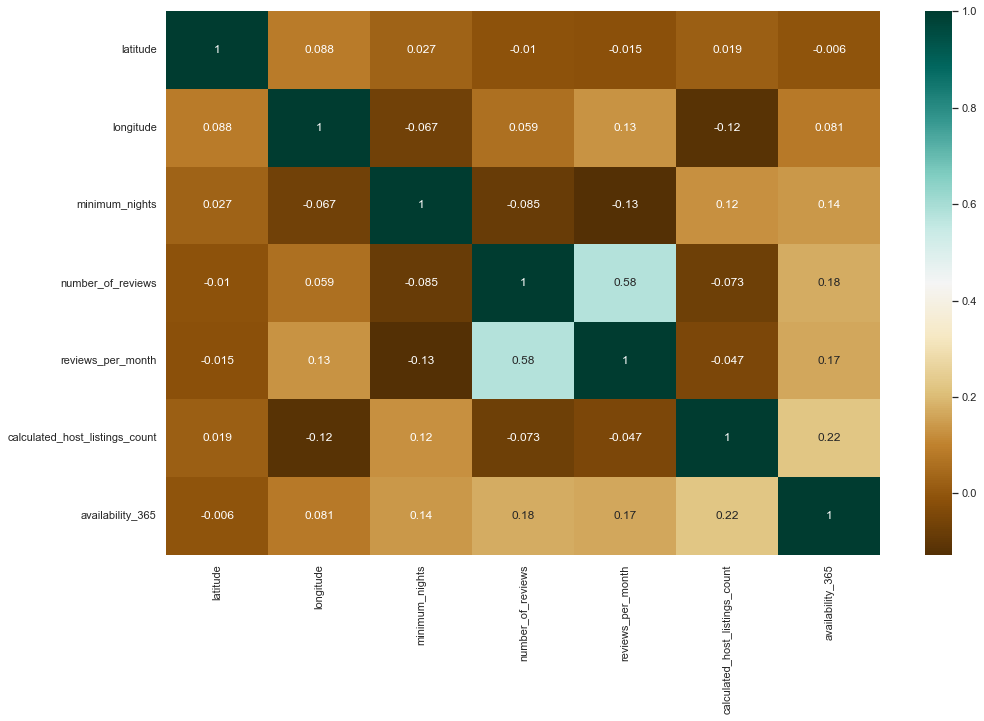

In [247]:
plt.figure(figsize=(16, 10))
sns.heatmap(corr, cmap='BrBG',  annot=True)

Ans:
- number of reviews
- reviews_per_month

### Make price binary

- We need to turn the price variable from numeric into binary.
- Let's create a variable `above_average` which is `1` if the price is above (or equal to) `152`.

In [248]:
# above_average = (y_train >= 152).astype(int)

### Question 3

- Calculate the mutual information score with the (binarized) price for the two categorical variables that we have. Use the training set only.
- Which of these two variables has bigger score?
- Round it to 2 decimal digits using `round(score, 2)`

<AxesSubplot:>

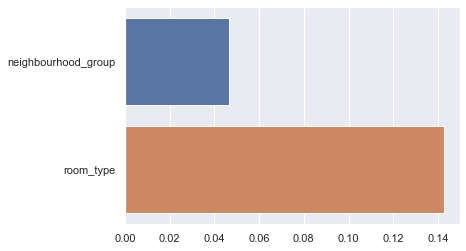

In [249]:
mi = df_train[cat_columns].apply(lambda s: mutual_info_score(s, y_train))
sns.barplot(x=mi, y=mi.index)

Ans: room_type, around 0.14

### Question 4

- Now let's train a logistic regression
- Remember that we have two categorical variables in the data. Include them using one-hot encoding.
- Fit the model on the training dataset.
  - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
  - `model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)`
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.


In [250]:
transformer = make_column_transformer(
    (OneHotEncoder(), cat_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X_train = transformer.fit_transform(df_train)

In [251]:
df_info2(df_train)

,dtype,#,#na,#unique,min,max
neighbourhood_group,object,29337,0,5,bronx,staten_island
room_type,object,29337,0,3,entire_home/apt,shared_room
latitude,float64,29337,0,15291,40.49979,40.91169
longitude,float64,29337,0,12082,-74.24084,-73.71299
minimum_nights,int64,29337,0,88,1,1250
number_of_reviews,int64,29337,0,351,0,607
reviews_per_month,float64,29337,0,855,0.0,58.5
calculated_host_listings_count,int64,29337,0,47,1,327
availability_365,int64,29337,0,366,0,365


In [252]:
model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [253]:
model.score(transformer.transform(df_val), y_val)

0.8004908477349422

Ans: 80%

### Question 5

- We have 9 features: 7 numerical features and 2 categorical.
- Let's find the least useful one using the _feature elimination_ technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
- Which of following feature has the smallest difference?
  - `neighbourhood_group`
  - `room_type`
  - `number_of_reviews`
  - `reviews_per_month`

> **note**: the difference doesn't have to be positive

In [254]:
base_acc = model.score(transformer.transform(df_val), y_val)
accs = []

for col in df_X.columns:
    transformer = make_column_transformer(
        (OneHotEncoder(), [c for c in cat_columns if c != col]),
        (StandardScaler(), [c for c in num_columns if c != col]),
        remainder='passthrough'
    )

    model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42)
    XX_train = transformer.fit_transform(df_train.drop(col, axis=1))
    model.fit(XX_train, y_train)

    XX_val = transformer.transform(df_val.drop(col, axis=1))
    score = model.score(XX_val, y_val)
    accs.append(score)

In [255]:
differences = base_acc - np.array(accs)
df_X.columns[np.argmin(differences)]

'number_of_reviews'

### Question 6

- For this question, we'll see how to use a linear regression model from Scikit-Learn
- We'll need to use the original column `'price'`. Apply the logarithmic transformation to this column.
- Fit the Ridge regression model on the training data.
- This model has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`
- Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

If there are multiple options, select the smallest `alpha`.


In [256]:
y = np.log1p(df['price'].values)
df_train, df_test, y_train, y_test = train_test_split(df_X, y, test_size=0.4, random_state=42, shuffle=True)
df_val, df_test, y_val, y_test = train_test_split(df_test, y_test, test_size=0.5, shuffle=False)

In [257]:
alphas = [0, 0.01, 0.1, 1, 10]
transformer = make_column_transformer(
    (OneHotEncoder(), cat_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

In [258]:
rmses = []
for alpha in alphas:
    model = Ridge(alpha=alpha, random_state=42)
    model.fit(transformer.fit_transform(df_train), y_train)
    y_hat = model.predict(transformer.fit_transform(df_val))
    rmse = mean_squared_error(y_hat, y_val, squared=False)
    rmses.append(round(rmse, 3))
idx = np.argmin(rmses)
alphas[idx], rmses[idx]

/Users/jchien/Library/Caches/pypoetry/virtualenvs/ml-zoomcamp-5e_EmHlr-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.89238e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


(0, 0.486)

Ans: 0